In [1]:
import torch

data = torch.load('ttt_data_tensors.pt')

In [2]:
X = data['X']
y = data['y']

In [3]:
X.shape

torch.Size([209088, 9])

In [5]:
print(f'X: {X.shape}/{X.dtype} | y: {y.shape}/{y.dtype}')

X: torch.Size([209088, 9])/torch.float32 | y: torch.Size([209088])/torch.int64


In [18]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

In [7]:
class NN(nn.Module):
    def __init__(self, neurons, num_classes):
        super(NN, self).__init__()

        self.neurons = neurons

        for i in range(len(neurons)):
            if i == len(neurons) - 1:
                setattr(self, f'fc{i+1}', nn.Linear(neurons[i], num_classes))
            else:
                setattr(self, f'fc{i+1}', nn.Linear(neurons[i], neurons[i+1]))

    def forward(self, x):

        for i in range(len(self.neurons)):
            if i == len(self.neurons) - 1:
                x = getattr(self, f'fc{i+1}')(x)
            else:
                x = torch.tanh(getattr(self, f'fc{i+1}')(x))

        return x

In [8]:
def train_model(model, dataloader, criterion, optimizer, device, iterations):
    model.to(device)
    loss_values = []
    acc_values = []

    for i in range(iterations):
        model.train()
        epoch_loss, epoch_total, epoch_correct = 0, 0, 0

        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            epoch_loss += loss.item()
            epoch_correct += (predicted == y_batch).sum().item()
            epoch_total += y_batch.size(0)

        loss_values.append(epoch_loss / len(dataloader))
        acc_values.append(100 * epoch_correct / epoch_total)

        # if i == 0 or i %  == 0 or i == iterations - 1:
        print(f'Iteration {i}: Loss -> {loss_values[-1]} | Accuracy -> {acc_values[-1]}')

    return loss_values, acc_values

In [9]:
def evaluate_model(model, X_test, y_test, device):
    model.to(device)
    model.eval()

    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        
        correct = (predicted == y_test).sum().item()
        total = y_test.size(0)
        accuracy = 100 * correct / total

    return accuracy

In [10]:
def plot_results(loss_values, acc_values):

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].plot(loss_values, label='Loss', color='blue')
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(acc_values, label='Accuracy', color='green')
    axes[1].set_title('Training Accuracy')
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Accuracy %')
    axes[1].legend()

    plt.show()

In [11]:
# def FullNN(model, X_train, X_test, y_train, y_test, optimizer, criterion, device, iterations):
#     loss, acc = train_model(model, X_train, y_train, criterion, optimizer, device, iterations)
#     test_acc = evaluate_model(model, X_test, y_test, device)
#     plot_results(loss, acc)

#     print(f'Test accuracy = {test_acc}')
#     return test_acc

In [20]:
def FullNN_last(model, X, y, optimizer, criterion, device, b_size, iterations):
    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=b_size, shuffle=True)
    loss, acc = train_model(model, dataloader, criterion, optimizer, device, iterations)

    plot_results(loss, acc)

In [21]:
model = NN([X.shape[1], 150, 300, 150], 9)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Iteration 0: Loss -> 0.5349509821819413 | Accuracy -> 78.02025941230487
Iteration 1: Loss -> 0.4584766057122731 | Accuracy -> 79.63680364248546
Iteration 2: Loss -> 0.44417413763674557 | Accuracy -> 79.66215182124273
Iteration 3: Loss -> 0.4330841641841203 | Accuracy -> 79.88406795224977
Iteration 4: Loss -> 0.4257632592827483 | Accuracy -> 79.96298209366391
Iteration 5: Loss -> 0.42436144213708554 | Accuracy -> 80.05002678298133
Iteration 6: Loss -> 0.4209010032264372 | Accuracy -> 79.92902509947965
Iteration 7: Loss -> 0.42363194259501435 | Accuracy -> 80.04859198041017
Iteration 8: Loss -> 0.4198453584400939 | Accuracy -> 80.01224364860728
Iteration 9: Loss -> 0.42076492152715983 | Accuracy -> 80.04141796755434
Iteration 10: Loss -> 0.4179314381033729 | Accuracy -> 80.1380280073462
Iteration 11: Loss -> 0.41656796907780363 | Accuracy -> 80.04763544536272


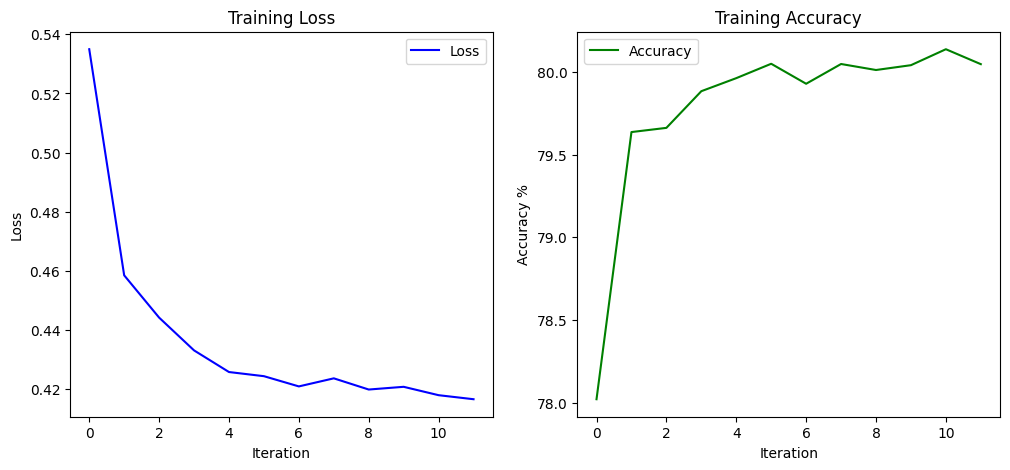

In [22]:
FullNN_last(model, X, y, optimizer, criterion, device, 128, 12)

In [23]:
torch.save(model.state_dict(), 'ttt_model.pth')